In [1]:
import joblib

filename = "Log/ppo1TFS-02262021-114243-victim/model/ppo1-advtrain-trajectory-test.data"
trajectory_dic = joblib.load(filename)
    



In [4]:
trajectory_dic['all_obvs'].shape

(4000000, 13)

In [5]:
from utils.helper import pca_analysis,traj_stat_analysis
orig_observations,all_actions,all_dones,all_rewards,all_hidden = traj_stat_analysis(trajectory_dic)

(3999968, 13)
(3999968, 2)
(3999968,)
(3999968,)
(3999968, 8)
min obversations: [-1.04 -1.73 -1.01 -1.48 -1.04 -1.44 -1.01 -1.48 -0.91 -6.02 -1.04 -5.96
 -1.  ]
max obversations: [1.04 1.49 1.01 1.48 1.04 1.44 1.01 1.48 0.89 5.97 1.03 5.55 0.  ]
min actions: [-1. -1.]
max actions: [1. 1.]


In [6]:
logdir = "Log/ppo1TFS-02262021-114243-victim/model/"
profiling_folder = logdir + "profiling/"

n_components = 6
pcaModelPath = profiling_folder + "pcaModel_n{}.job".format(n_components)
pcaModel, pca_dic = pca_analysis(n_components,pcaModelPath,all_hidden,True)

Load saved pca model successfully!


In [7]:
import numpy as np
np.around(pca_dic['pca_data'][:10],4)

array([[-1.9819,  1.5097,  0.2601,  0.5986, -0.1241, -0.0087],
       [-2.0176,  0.7863,  0.3141,  0.0836,  0.0904, -0.1363],
       [-1.923 ,  1.3977,  0.3045,  0.4885, -0.2539,  0.0148],
       [-2.0086,  1.3778,  0.3266,  0.4805, -0.1042, -0.0419],
       [-2.029 ,  1.2438,  0.3364,  0.3891, -0.0416, -0.0777],
       [-2.0317,  1.2167,  0.3215,  0.3819, -0.0256, -0.0934],
       [-2.0472,  1.0576,  0.3318,  0.2709,  0.0378, -0.1268],
       [-2.0525,  1.0003,  0.3301,  0.2341,  0.064 , -0.1402],
       [-2.0658,  0.8747,  0.3455,  0.1408,  0.1177, -0.16  ],
       [-2.0473,  1.0237,  0.3439,  0.2359,  0.0561, -0.115 ]],
      dtype=float32)

In [8]:
from utils.helper import dtmc_abs_analysis
grid_num = 8
abs_profiling_file = profiling_folder + "profilingRes_g{}_n{}.dic".format(grid_num, n_components)
profiling_dic = dtmc_abs_analysis(pca_dic, None, grid_num,abs_profiling_file)


Load profiling results from Log/ppo1TFS-02262021-114243-victim/model/profiling/profilingRes_g8_n6.dic successfully!


In [9]:
dtmc = profiling_dic['dtmc']
abs_states = dtmc.state_abstract(con_states = pca_dic['pca_data'])

In [10]:
abs_traces, tracesLen, results = dtmc.extract_abs_trace(all_rewards,abs_states)

Total traces:22722
Success:4304
Failure:18418


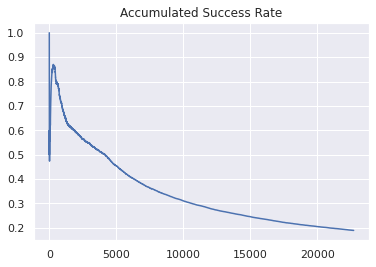

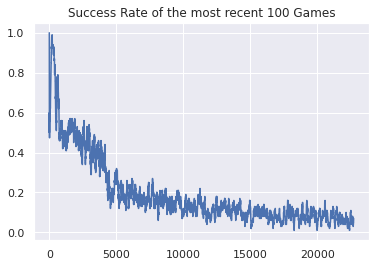

In [11]:
from utils.plot_func import plot_successRate
plot_successRate(results,True,title="Accumulated Success Rate")
plot_successRate(results,False, title="Success Rate of the most recent 100 Games")
# show_hist(np.array(profiling_dic['abs_states'],dtype=np.int32),bin=100,range=None,title="distribution of abstract states")

In [12]:
def calc_coverage(abs_states,grid_num,n_componenct):
    uniq = len(np.unique(np.array(abs_states)))
    total = pow(grid_num, n_componenct)
    print("The number of unique states:{}".format(uniq))
    print("The number of total states:{}".format(total))
    print("Coverage:{:.2f}".format((uniq*1.0)/total))

calc_coverage(abs_states,grid_num,n_components)

The number of unique states:13171
The number of total states:262144
Coverage:0.05


In [13]:
uniq_states = np.unique(np.array(profiling_dic['abs_states']))

In [14]:
new_uniq_states = np.unique(np.array(abs_states))

In [15]:
new_states = []
covered_states = []
for uniq in new_uniq_states:
    if uniq not in uniq_states:
        new_states.append(uniq)
    else:
        covered_states.append(uniq)

print("New trajectories covered {} old abstract states.".format(len(covered_states)))
print("New trajectories discovered {} new abstract states.".format(len(new_states)))

New trajectories covered 8288 old abstract states.
New trajectories discovered 4883 new abstract states.


In [16]:
from utils.helper import analyze_abstraction

In [17]:
avgFreq, abs2con, state_dic, transistion_dic = analyze_abstraction(abs_states, abs_traces)
occurance = []
for key,val in state_dic.items():
    occurance.append(val[0]+val[1])
occurance = np.array(sorted(occurance))
percent95 = int(np.percentile(occurance,95))
print("total covered states:",len(occurance))
print("when we choose avgFreq threshold (i.e.,{}) to filter rare states, only {} abstract states are kept.".format(
    int(avgFreq),len(np.where(occurance>avgFreq)[0])))
print("when we choose percent95 threshold (i.e.,{}) to filter rare states, only {} abstract states are kept.".format(
    percent95,len(np.where(occurance>percent95)[0])))

total covered states: 13171
when we choose avgFreq threshold (i.e.,303) to filter rare states, only 950 abstract states are kept.
when we choose percent95 threshold (i.e.,495) to filter rare states, only 659 abstract states are kept.


In [18]:
print("when we choose profiling percent95 threshold (i.e.,680) to filter rare states, only {} abstract states are kept.".format(
    len(np.where(occurance>680)[0])))

when we choose profiling percent95 threshold (i.e.,680) to filter rare states, only 518 abstract states are kept.


In [21]:
from utils.helper import fetchCriticalState

savepath = profiling_folder + "ppo1adv_critical_states.dic"
critical, good_list, bad_list = fetchCriticalState(state_dic, 680, threshold=0.35, savepath=savepath)

good state: 0
bad state: 479
Save critical states info to  Log/ppo1TFS-02262021-114243-victim/model/profiling/ppo1adv_critical_states.dic


In [23]:
import joblib

loadpath = profiling_folder + "critical_states.dic"
critical_dic = joblib.load(loadpath)


In [24]:
for bad in critical_dic['bad_list']:
    if bad in bad_list:
        print(bad,True)
    else:
        print(bad)

47300 True
108982
141750
80069 True
83680 True
109799 True
178227


In [41]:
for good in critical_dic['good_list']:
    if good in good_list:
        print(good,True)
    else:
        print(good)

170027
169516 True
111783
137259
109097
169507
169515
173258
173165 True
108122
108578
173092 True
173091
172572
140379
172571 True
173677 True
47201
169508
140398
47193
109089
168995
136739
140910
172635 True
173083
145603
109098
137251
145098
140995
